In [310]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import rpy2
from pprint import pprint
import re
import numpy as np
import pickle
from skbio.alignment import StripedSmithWaterman, local_pairwise_align_ssw
%run lib.ipynb

In [255]:
path = "../../david_eccles_bc_ideas/"
SRATE = 5000

In [256]:
robjects.r['load']("../../david_eccles_bc_ideas/mtDNA_mappable_called_with_rawSignal.Rdata")

<StrVector - Python:0x7f3c4b0b4748 / R:0x30a7248>
['nanopore.bundled']

In [257]:
data = numpy2ri.ri2py(robjects.r['nanopore.bundled'])

In [258]:
files = !ls ../../david_eccles_bc_ideas/processed/ | grep fast5

In [260]:
result = re.search(r'_ch(\d+)_file(\d+)_', file)
file_id = int(result.group(2))
channel_id = int(result.group(1))
print(channel_id, file_id)

132 10


### Get data from RData

0 = reference
1 = called
3 = channel
8 = metrichor results (events)
9 = "mux"
10 = signal range 
11 = signal

In [261]:
ref = data[0][0]
channel_ids = [int(x) for x in data[3]]
file_ids = [int(x) for x in data[5]]
types = list(data[2].names)

In [262]:
## channel coords from rdata
coords = []
for i in range(0, len(data[10]), 2):
    coords.append((round(data[10][i]), round(data[10][i+1])))

all_raw = np.empty(round(max(data[10])))
all_raw.fill(-1)

pack all the available raw signal for the given channel in one array. 

In [275]:
for i, start_end in enumerate(coords):
    if channel_ids[i] == channel_id and file_ids[i] == file_id:
        start, end = start_end
        print(i, start)
        for k, sig in enumerate(data[11][i]):
            all_raw[start + k] = sig

0 14263383
1 14263383


### Get events and sequence via poretools 

only look at the "template" seq for the beginning

In [276]:
called_seq = !poretools fasta {path+"processed/" + file} | grep template -A1 | grep -v ">"
called_seq = called_seq[0]

In [277]:
events = !poretools events {path+"processed/" + file} | grep template

file	strand	mean	start	stdv	length	model_state	model_level	move	p_model_state	mp_model_state	p_mp_model_state	p_A	p_C	p_G	p_T	raw_index

In [278]:
events = [line.split("\t") for line in events]

In [279]:
start = round(float(events[0][3]) * SRATE)
end = round(float(events[-1][3]) * SRATE)
print (start, end)

14263383 15169026


In [289]:
raw_events = []
for ev in events: 
    r_ev = dict()
    r_ev["start"] = round(float(ev[3]) * SRATE)
    r_ev["end"] = round(r_ev["start"] + float(ev[5]) * SRATE)
    r_ev["mp_kmer"] = ev[10] #maximum posterior
    r_ev["kmer"] = ev[6] #model state
    r_ev["move"] = int(ev[8])
    raw_events.append(r_ev)

In [290]:
from pylab import * 
import seaborn as sns
%matplotlib inline
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})

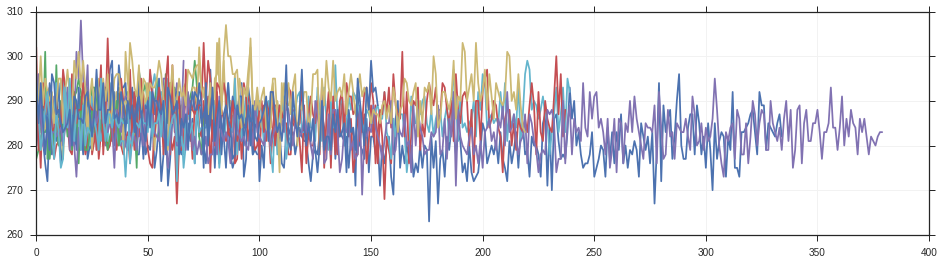

In [291]:
fig, ax = subplots(figsize = (16,4))
for ev in raw_events:
    if ev["mp_kmer"] == "AAAAA":
        ax.plot(list(all_raw[ev["start"]:ev["end"]]))

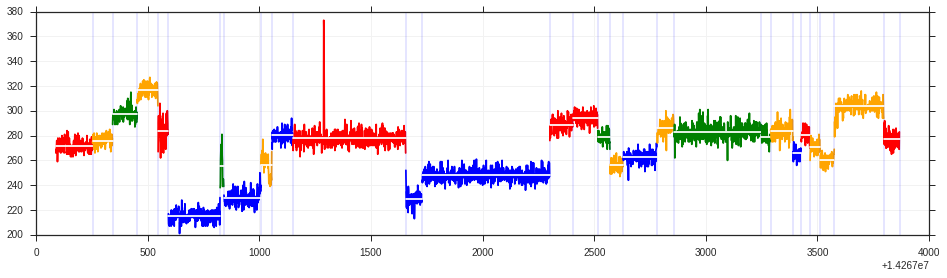

In [294]:
cols = {"A": "red", "T": "blue", "G": "green", "C": "orange"}
fig, ax = subplots(figsize = (16,4))
for ev in raw_events[22:50]:
    mean = np.mean(all_raw[ev["start"]:ev["end"]])
    if move == 1: 
        col = cols[ev["mp_kmer"][2]]
    elif move == 0: 
        col = "black"
    else:
        col = "purple"
    ax.plot(range(ev["start"], ev["end"]), list(all_raw[ev["start"]:ev["end"]]), color=col)
    ax.axvline(ev["end"], linewidth=.2)
#     ax.annotate("xx", xy=(start-ev0, mean + 40), xycoords="data")
    ax.plot((ev["start"], ev["end"]), [mean] * 2, color="white")


In [295]:
align_ref = StripedSmithWaterman(ref, gap_open_penalty=5, gap_extend_penalty=2)
alignment = align_ref(called_seq)

In [296]:
print(alignment.query_begin, alignment.query_end)
als = alignment.query_begin
print(" " * als + alignment.aligned_target_sequence[:90])
print(" " * als + alignment.aligned_query_sequence[:90])
print(alignment.query_sequence[:90])

22 6535
                      GCATAGCA-TGAAAATGCTTAGATGGATAAT--TATCCC---AGCTC--AGGTTATTTAAC---TCGTATAATCCAATTAGAG--GTAAT
                      GCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACA-CAAAGGTTTGGTCCT-GGCCTTATAATTAATTAGAGGTAAAAT
GTTAATGTAGCTTAATAACAAAGCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACACAAAGGTTTGGTCCTGGCCTTA


#How does Metrichor assemble the reads?  

In [331]:
print(raw_events[:5])

[{'move': 0, 'kmer': 'CTACG', 'start': 14263383, 'end': 14263425, 'mp_kmer': 'CTACG'}, {'move': 1, 'kmer': 'TACGG', 'start': 14263425, 'end': 14263799, 'mp_kmer': 'ACACT'}, {'move': 1, 'kmer': 'ACGGG', 'start': 14263799, 'end': 14263877, 'mp_kmer': 'CACTG'}, {'move': 1, 'kmer': 'CGGGA', 'start': 14263877, 'end': 14263958, 'mp_kmer': 'CTGAA'}, {'move': 1, 'kmer': 'GGGAT', 'start': 14263958, 'end': 14263999, 'mp_kmer': 'TGAAT'}]


In [339]:
seq = []
seq.extend(raw_events[0]["kmer"])
for ev in raw_events[1:]:
    if(ev["move"] == 0): continue
    seq.extend(ev["kmer"][-ev["move"]:])

seq = "".join(seq)
l, r = (0, 100)
print(seq[l:r])
print(called_seq[l:r])
print("".join(["*" if seq[i] == called_seq[i] else " " for i in range(l, r)]))
print(length_standard(r-l))

print(seq == called_seq)

CTACGGGATTGGGGGCTAACCGTGCCATACGCATTCTTCTATTAAAACTAGCTACTCATCGCTCTTCTCAATCATCTTAATTTATATCAGTCTCAGGAAG
CTACGGGATTGGGGGCTAACCGTGCCATACGCATTCTTCTATTAAAACTAGCTACTCATCGCTCTTCTCAATCATCTTAATTTATATCAGTCTCAGGAAG
****************************************************************************************************
0....:....1....:....2....:....3....:....4....:....5....:....6....:....7....:....8....:....9....:....
True


In [327]:
def length_standard(n):
    out = []
    for i in range(n):
        if i % 10 == 0:
             out.append(int((i - 100*int(i/100)) / 10))
        elif i % 5 == 0:
            out.append(":")
        else:
            out.append(".")
    return "".join(map(str, out))